# Understanding Twitter propaganda accounts

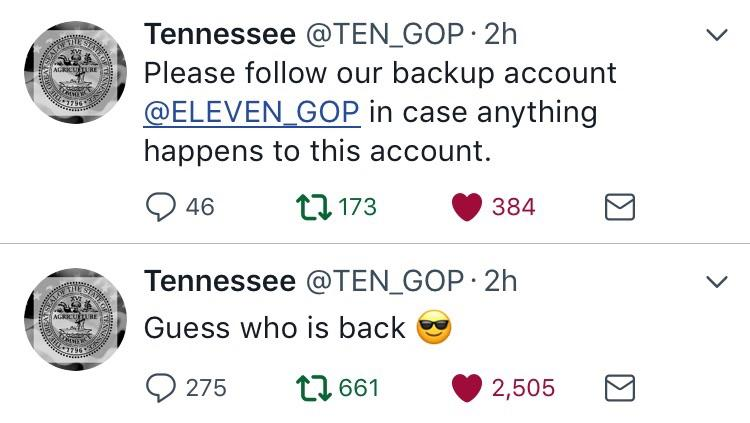

In [3]:
from IPython.display import Image
Image(filename='data/ten_gop.jpg') 

# Cleaning Twitter content

In [1]:
import os
import re
import sqlite3 as sql
import emoji
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

plt.style.use('fivethirtyeight')
#%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_colwidth = 250

In [22]:
if not os.path.exists('data/fivethirtyeight_tweets.csv'):
    with open('data/fivethirtyeight_tweets.csv', 'w'):
        for ii in range(1,12):
            print('Accessing file '+str(ii)+' of 11...')
            if ii == 1:
                ira_tweets_538 = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/russian-troll-tweets/master/IRAhandle_tweets_'+str(ii)+'.csv')
            else:
                more = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/russian-troll-tweets/master/IRAhandle_tweets_'+str(ii)+'.csv')
                ira_tweets_538 = pd.concat([ira_tweets, more])
        ira_tweets_538.to_csv('data/fivethirtyeight_tweets.csv')
        print('Done.')
        pass
else:
    print('Opening existing data file...')
    ira_tweets_538 = pd.read_csv('data/fivethirtyeight_tweets.csv')
    print('Done.')

Opening existing data file...
Done.


In [23]:
ira_tweets_538.columns

Index(['Unnamed: 0', 'external_author_id', 'author', 'content', 'region',
       'language', 'publish_date', 'harvested_date', 'following', 'followers',
       'updates', 'post_type', 'account_type', 'retweet', 'account_category',
       'new_june_2018', 'alt_external_id', 'tweet_id', 'article_url',
       'tco1_step1', 'tco2_step1', 'tco3_step1'],
      dtype='object')

In [24]:
ira_tweets_538.loc[0:5,['author','content']]

,author,content
0,10_GOP,"""We have a sitting Democrat US Senator on trial for corruption and you've barely heard a peep from the mainstream media."" ~ @nedryun https://t.co/gh6g0D1oiC"
1,10_GOP,Marshawn Lynch arrives to game in anti-Trump shirt. Judging by his sagging pants the shirt should say Lynch vs. belt https://t.co/mLH1i30LZZ
2,10_GOP,"Daughter of fallen Navy Sailor delivers powerful monologue on anthem protests, burns her NFL packers gear. #BoycottNFL https://t.co/qDlFBGMeag"
3,10_GOP,"JUST IN: President Trump dedicates Presidents Cup golf tournament trophy to the people of Florida, Texas and Puerto Rico. https://t.co/z9wVa4djAE"
4,10_GOP,"19,000 RESPECTING our National Anthem! #StandForOurAnthem🇺🇸 https://t.co/czutyGaMQV"
5,10_GOP,"Dan Bongino: ""Nobody trolls liberals better than Donald Trump."" Exactly! https://t.co/AigV93aC8J"


Drop columns that I will not use

In [25]:
ira_tweets_538 = ira_tweets_538.drop(['region','Unnamed: 0','article_url','tco1_step1','tco2_step1','tco3_step1'], axis=1)

Select only tweets in English

In [26]:
eng_tweets = ira_tweets_538[ira_tweets_538.language == 'English']
eng_tweets = eng_tweets[eng_tweets.account_category != 'NonEnglish']

In [28]:
eng_tweets.loc[0:5,['author','content']]

,author,content
0,10_GOP,"""We have a sitting Democrat US Senator on trial for corruption and you've barely heard a peep from the mainstream media."" ~ @nedryun https://t.co/gh6g0D1oiC"
1,10_GOP,Marshawn Lynch arrives to game in anti-Trump shirt. Judging by his sagging pants the shirt should say Lynch vs. belt https://t.co/mLH1i30LZZ
2,10_GOP,"Daughter of fallen Navy Sailor delivers powerful monologue on anthem protests, burns her NFL packers gear. #BoycottNFL https://t.co/qDlFBGMeag"
3,10_GOP,"JUST IN: President Trump dedicates Presidents Cup golf tournament trophy to the people of Florida, Texas and Puerto Rico. https://t.co/z9wVa4djAE"
4,10_GOP,"19,000 RESPECTING our National Anthem! #StandForOurAnthem🇺🇸 https://t.co/czutyGaMQV"
5,10_GOP,"Dan Bongino: ""Nobody trolls liberals better than Donald Trump."" Exactly! https://t.co/AigV93aC8J"


Remove website urls

In [29]:
eng_tweets['content'] = eng_tweets.content.str.replace('((www\.[^\s]+)|(http?://[^\s]+)|(https?://[^\s]+))','')
eng_tweets.loc[0:5,['author','content']]

,author,content
0,10_GOP,"""We have a sitting Democrat US Senator on trial for corruption and you've barely heard a peep from the mainstream media."" ~ @nedryun"
1,10_GOP,Marshawn Lynch arrives to game in anti-Trump shirt. Judging by his sagging pants the shirt should say Lynch vs. belt
2,10_GOP,"Daughter of fallen Navy Sailor delivers powerful monologue on anthem protests, burns her NFL packers gear. #BoycottNFL"
3,10_GOP,"JUST IN: President Trump dedicates Presidents Cup golf tournament trophy to the people of Florida, Texas and Puerto Rico."
4,10_GOP,"19,000 RESPECTING our National Anthem! #StandForOurAnthem🇺🇸"
5,10_GOP,"Dan Bongino: ""Nobody trolls liberals better than Donald Trump."" Exactly!"


Remove emojis

In [30]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)

eng_tweets.content = eng_tweets.content.apply(lambda x: emoji_pattern.sub(r'', str(x)))
eng_tweets.loc[0:5,['author','content']]

,author,content
0,10_GOP,"""We have a sitting Democrat US Senator on trial for corruption and you've barely heard a peep from the mainstream media."" ~ @nedryun"
1,10_GOP,Marshawn Lynch arrives to game in anti-Trump shirt. Judging by his sagging pants the shirt should say Lynch vs. belt
2,10_GOP,"Daughter of fallen Navy Sailor delivers powerful monologue on anthem protests, burns her NFL packers gear. #BoycottNFL"
3,10_GOP,"JUST IN: President Trump dedicates Presidents Cup golf tournament trophy to the people of Florida, Texas and Puerto Rico."
4,10_GOP,"19,000 RESPECTING our National Anthem! #StandForOurAnthem"
5,10_GOP,"Dan Bongino: ""Nobody trolls liberals better than Donald Trump."" Exactly!"


Add two new columns: list of hashtags in tweet, list of @ mentions

In [31]:
'''
#.*?     -- non-greedy match for words starting with #
(?=\s|$) -- look ahead for the end of the word
'''
eng_tweets['hashtags'] = eng_tweets.content.str.findall(r'#.*?(?=\s|$)')
eng_tweets['mentions'] = eng_tweets.content.str.findall(r'@.*?(?=\s|$)')

Remove punctuation

In [32]:
eng_tweets.content = eng_tweets.content.apply(lambda x: re.sub('[^A-Za-z0-9\' ]+', '', str(x)))
eng_tweets.loc[0:5,['author','content']]

,author,content
0,10_GOP,We have a sitting Democrat US Senator on trial for corruption and you've barely heard a peep from the mainstream media nedryun
1,10_GOP,Marshawn Lynch arrives to game in antiTrump shirt Judging by his sagging pants the shirt should say Lynch vs belt
2,10_GOP,Daughter of fallen Navy Sailor delivers powerful monologue on anthem protests burns her NFL packers gear BoycottNFL
3,10_GOP,JUST IN President Trump dedicates Presidents Cup golf tournament trophy to the people of Florida Texas and Puerto Rico
4,10_GOP,19000 RESPECTING our National Anthem StandForOurAnthem
5,10_GOP,Dan Bongino Nobody trolls liberals better than Donald Trump Exactly


In [33]:
#eng_tweets.content = eng_tweets.content.apply(lambda x: re.sub('[,.!$%&*?;:@#~-+=/]+', '', str(x)))

Split CamelCase words for improved entity recognition

In [34]:
eng_tweets.content = eng_tweets.content.apply(lambda x: re.sub("([a-z])([A-Z])","\g<1> \g<2>", str(x)))
eng_tweets.loc[0:5,['author','content']]

,author,content
0,10_GOP,We have a sitting Democrat US Senator on trial for corruption and you've barely heard a peep from the mainstream media nedryun
1,10_GOP,Marshawn Lynch arrives to game in anti Trump shirt Judging by his sagging pants the shirt should say Lynch vs belt
2,10_GOP,Daughter of fallen Navy Sailor delivers powerful monologue on anthem protests burns her NFL packers gear Boycott NFL
3,10_GOP,JUST IN President Trump dedicates Presidents Cup golf tournament trophy to the people of Florida Texas and Puerto Rico
4,10_GOP,19000 RESPECTING our National Anthem Stand For Our Anthem
5,10_GOP,Dan Bongino Nobody trolls liberals better than Donald Trump Exactly


In [14]:
#eng_tweets.content = eng_tweets.content.apply(lambda x: re.sub("([a-z][0-9])([A-Z])","\g<1> \g<2>", str(x)))
#eng_tweets.content = eng_tweets.content.apply(lambda x: re.sub("([0-9])([a-z][A-Z])","\g<1> \g<2>", str(x)))

Remove RTs

In [59]:
eng_tweets.content = eng_tweets.content.str.replace('RT','')

Remove apostrophes

In [60]:
#eng_tweets.content = eng_tweets.content.str.replace("\'",'')

Remove 'amp'

In [61]:
eng_tweets.content = eng_tweets.content.str.replace(' amp ',' ')

Finally, remove any extra whitespace

In [62]:
eng_tweets.content = eng_tweets.content.apply(lambda x: re.sub('[\s]+', ' ', x))

Now split tweets into original content and retweets

In [63]:
user_original = eng_tweets[eng_tweets.retweet==0]
user_original = user_original.groupby('author',as_index=False).agg({'account_category': list, 'content': sum})
user_original.account_category = user_original.account_category.apply(lambda x: x[0])

user_rt = eng_tweets[eng_tweets.retweet==1]
user_rt = user_rt.groupby('author',as_index=False).agg({'account_category': list, 'content': sum})
user_rt.account_category = user_rt.account_category.apply(lambda x: x[0])
user_rt.head()

,author,account_category,content
0,10_GOP,RightTroll,Daughter of fallen Navy Sailor delivers powerful monologue on anthem protests burns her NFL packers gear Boycott NFL 19000 RESPECTING our National Anthem Stand For Our Anthem BREAKING The audio of sexual predator Harvey Weinstein admitting to as...
1,1D_NICOLE_,Fearmonger,Food Poisoning is not a joke Walmart Koch Farms Thanks God that turkey i ate few days ago was good Koch Farms
2,1ERIK_LEE,RightTroll,Why is someone even against the petition I'll watch you bleeding when some thug shoots your ass off No Guns For CriminalsIts reasonable to ban firearms sales in black areas No Guns For Criminals
3,4EVER_SUSAN,RightTroll,Raiders defense playing hungry Bending and not breaking Let's go offense Start Up the Carr Raider Nation We need to turn up the tempo RaidersI was shocked and heartbroken when CBS canceled Mike And Molly I would have shot this show for 50 more ye...
4,4MYSQUAD,LeftTroll,'politicalseason Maat Justice Injustice in Louisiana 16yearold got life without parole for throwing one punch nytimes You never become a howling success by just howling2k15 makes me feel the same way Utter bullshit Anyone can be brave with a badg...


In [64]:
eng_tweets.to_pickle('../data/eng_tweets.p')
user_original.to_pickle('../data/user_original.p')
user_rt.to_pickle('../data/user_rt.p')